In [51]:
import pandas as pd
import numpy as np
import time
import sys

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn import svm

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/supervised_learning/'
if module_path not in sys.path:
    sys.path.append(module_path)
    
from evaluation import *

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/'
if module_path not in sys.path:
    sys.path.append(module_path)
    
from cohort_loader import data_split

In [52]:
dataset = pd.read_csv('/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/MIMIC-IV-COHORT.csv.gz', compression='gzip', index_col=0)
mimic_train_ori, mimic_valid_ori = data_split(dataset, 9040, 0.7, Threshold=0.05, n_trial=1, mode = 'mimic') 

eicu = pd.read_csv('/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/eICU-COHORT.csv.gz', compression='gzip', index_col=0)
eicu = eicu.rename(columns = {'SaO2_fillna':'SpO2_fillna'})
eicu_test = data_split(eicu, 9040, 0.7, Threshold=0.05, n_trial=1, mode = 'eicu') 

========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.70, 테스트 = 0.30
학습셋 클래스 비율: 1    387626
2     11118
3     13863
4      3838
Name: classes, dtype: int64
테스트셋 클래스 비율: 1    157229
2      4903
3      6157
4      1666
Name: classes, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.93:0.03:0.03:0.01
테스트셋 클래스 비율: 0.93:0.03:0.04:0.01
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 6820
테스트셋 환자 수: 2923
학습셋 체류 수: 7096
테스트셋 체류 수: 3050
--------------------------------------
========== 실험 설정 ==========
분할 시드: 9040
학습 비율: 0.7
임계값: 0.05
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.44
시도한 시행 횟수: 0
========== 데이터셋 분할 정보 ==========
학습셋 클래스 비율: 1    863021
2     24359
3     13648
4      4138
Name: classes, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.95:0.03:0.02:0.00
--------------------------------------
========== 환자 및 체류 정보 ==========
학습

In [53]:
eicu_test = eicu_test[~(eicu_test['gender']==2)]

In [54]:
# for training: circ 상태 10% 포함 

circ_data = mimic_train_ori[(mimic_train_ori['Annotation'] == 'circ')|(mimic_train_ori['Annotation'] == 'ambiguous')]
circ_data_sample = circ_data.sample(frac=0.1, random_state=1) 

non_circ_data = mimic_train_ori[(mimic_train_ori['Annotation'] == 'no_circ')]
new_dataset = pd.concat([circ_data_sample, non_circ_data])

sampled_dataset = new_dataset.reset_index(drop=True)

In [55]:
# mimic_valid_ori = mimic_valid_ori[~(mimic_valid_ori['Annotation'] == 'ambiguous')]
# eicu_test = eicu_test[~(eicu_test['Annotation'] == 'ambiguous')]

X_train, y_train, _ = split_X_Y(sampled_dataset, mode = 'mimic')
X_valid, y_valid, valid_output = split_X_Y(mimic_valid_ori, mode = 'mimic')
X_test, y_test, test_output = split_X_Y(eicu_test, mode = 'eicu')

In [56]:
lgbm_wrapper = LGBMClassifier(n_estimators=10, random_state=42)
lgbm_wrapper.fit(X_train, y_train)

valid_preds = lgbm_wrapper.predict(X_valid)
valid_output['prediction_label'] = valid_preds
valid_output['prediction_prob'] = lgbm_wrapper.predict_proba(X_valid)[:, 1]

test_preds = lgbm_wrapper.predict(X_test)
test_output['prediction_label'] = test_preds
test_output['prediction_prob'] = lgbm_wrapper.predict_proba(X_test)[:, 1]
# pred_proba = lgbm_wrapper.predict_proba(X_valid)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15351, number of negative: 387634
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30429
[LightGBM] [Info] Number of data points in the train set: 402985, number of used features: 205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038093 -> initscore=-3.228881
[LightGBM] [Info] Start training from score -3.228881


In [57]:
module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/'
if module_path not in sys.path:
    sys.path.append(module_path)

from cohort_evaluation import get_evaluation

In [58]:
recall, precision = get_evaluation(valid_output.iloc[:, :-1], 'mimic')
recall_test, precision_test = get_evaluation(test_output.iloc[:, :-1], 'eicu')

print('mimic validation: ', recall, precision)
print('eicu test: ', recall_test, precision_test)

100%|██████████| 9847/9847 [00:18<00:00, 533.76it/s]

mimic validation:  0.8187 0.9204
eicu test:  0.4444 0.7939


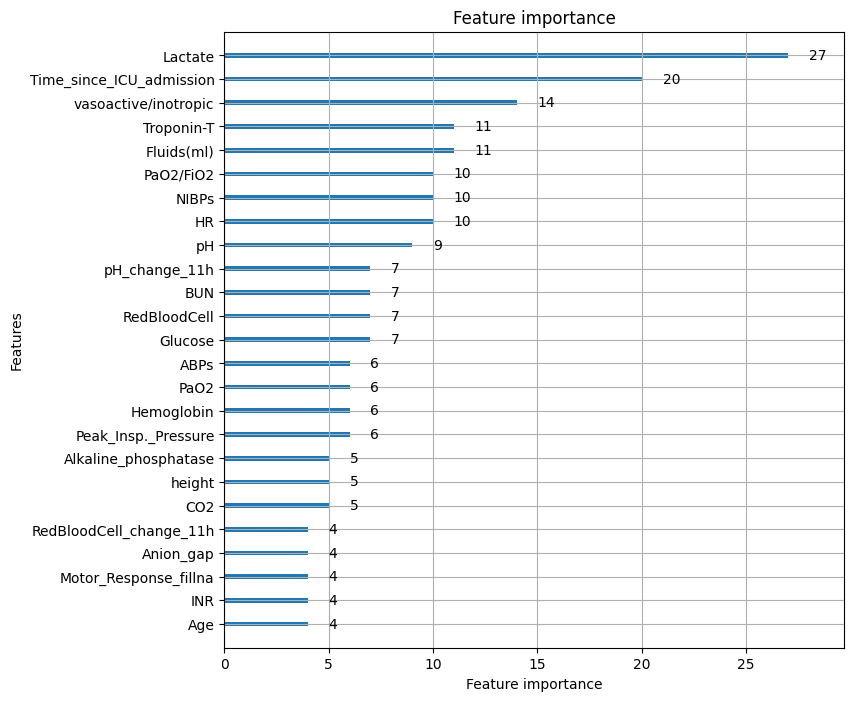

In [60]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(8,8))
plot_importance(lgbm_wrapper, max_num_features = 25, ax = ax)
plt.show()